In [1]:
from rdkit import Chem, DataStructs
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import (Draw,
                        Descriptors,
                        AllChem)
from rdkit.Chem.AtomPairs import Pairs
import numpy as np
from pathlib import Path
import h5py as h5
from chembl_webresource_client.new_client import new_client
from string import Template
from pprint import pprint

# Carregar dados

In [2]:
DATA_DIR = Path('../data/')
data_filename = 'egfr_erbB1.h5'

In [3]:
data = h5.File(DATA_DIR / 'raw' / data_filename)

In [4]:
list(data.items() )

[('ap', <HDF5 group "/ap" (3 members)>),
 ('chembl_id', <HDF5 dataset "chembl_id": shape (6937,), type "|S13">),
 ('label', <HDF5 dataset "label": shape (6937,), type "<i8">),
 ('mg', <HDF5 group "/mg" (3 members)>),
 ('tt', <HDF5 group "/tt" (3 members)>),
 ('year', <HDF5 dataset "year": shape (6937,), type "<i8">)]

### Obtendo _Fingerprints_(FPs) de Morgan a partir de Chembl IDs

In [5]:
def chembl_to_smiles(chembl_id):
    # Fetch data from website and returns the smiles notation. Input = Chembl Id, Output = Smiles notation
    molecule = new_client.molecule
    return molecule.get(chembl_id)['molecule_structures']['canonical_smiles']

In [6]:
chembl_ids = list(map(lambda x: x.decode('utf-8'), data['chembl_id']))

In [7]:
print('{} ids to get FPs from.'.format(len(chembl_ids)))

6937 ids to get FPs from.


## Gerando FPs usando diferentes métodos: os bits ativados gerados são os mesmos?

In [8]:
fp_profile_template = Template(
    '$name --------\n'
    '# total bits: $n_total_bits\n'
    '# non-zero bits: $n_on_bits\n\n'
)

In [9]:
mol_smiles = chembl_to_smiles(chembl_ids[15])
mol = Chem.MolFromSmiles(mol_smiles)

In [10]:
bi_mg = {}
mg = AllChem.GetMorganFingerprint(mol,
                                    radius=2,
                                    bitInfo=bi_mg)

bi_mg_bit8k = {}
mg_bit_8k = AllChem.GetMorganFingerprintAsBitVect(mol,
                                                  radius=2,
                                                  nBits=8196,
                                                  bitInfo=bi_mg_bit8k)
bi_mg_bit2k = {}
mg_bit_2k = AllChem.GetMorganFingerprintAsBitVect(mol,
                                                  radius=2,
                                                  nBits=2048,
                                                  bitInfo=bi_mg_bit2k)

In [11]:
print(fp_profile_template.substitute(name='Using `AllChem.GetMorganFingerprint`',
                                     n_total_bits=mg.GetLength(),
                                     n_on_bits=len(mg.GetNonzeroElements())))

mg_bit_2k_arr = np.array(mg_bit_2k)
print(fp_profile_template.substitute(name='Using `AllChem.GetMorganFingerprintAsBitVect` w; radius=2, nBits = 2048',
                                     n_total_bits=len(mg_bit_2k_arr),
                                     n_on_bits=mg_bit_2k_arr.sum()))

mg_bit_8k_arr = np.array(mg_bit_8k)
print(fp_profile_template.substitute(name='Using `AllChem.GetMorganFingerprintAsBitVect` w; radius=2, nBits=8196',
                                     n_total_bits=len(mg_bit_8k_arr),
                                     n_on_bits=mg_bit_8k_arr.sum()))

Using `AllChem.GetMorganFingerprint` --------
# total bits: 4294967295
# non-zero bits: 72


Using `AllChem.GetMorganFingerprintAsBitVect` w; radius=2, nBits = 2048 --------
# total bits: 2048
# non-zero bits: 72


Using `AllChem.GetMorganFingerprintAsBitVect` w; radius=2, nBits=8196 --------
# total bits: 8196
# non-zero bits: 71




# Visualisando Bits de FPs de Morgan

In [12]:
sample_smiles = [chembl_to_smiles(cb) for cb in chembl_ids[:2]]
print(sample_smiles)
mols = [Chem.MolFromSmiles(sm) for sm in sample_smiles]

['COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OC', 'C=CC(=O)Nc1nc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc1CCCCN1CCOCC1']


In [13]:
print(sample_smiles[0])
bit_info1 = {}
mgfp_bit1 = AllChem.GetMorganFingerprintAsBitVect(mols[0], radius=2,
                                                  nBits=2048,
                                                  bitInfo=bit_info1)
list(bit_info1.items())[:5]

COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OC


[(191, ((10, 1),)),
 (216, ((12, 2),)),
 (249, ((1, 2), (21, 2))),
 (329, ((10, 2),)),
 (366, ((15, 1),))]

In [14]:
print(sample_smiles[1])
bit_info2 = {}
mgfp_bit2 = AllChem.GetMorganFingerprintAsBitVect(mols[1], radius=2,
                                                  nBits=2048,
                                                  bitInfo=bit_info2)
list(bit_info2.items())[:5]

C=CC(=O)Nc1nc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc1CCCCN1CCOCC1


[(50, ((21, 2),)),
 (80, ((24, 0), (25, 0), (26, 0), (27, 0))),
 (161, ((2, 2),)),
 (191, ((10, 1),)),
 (216, ((12, 2),))]

Cada dicionário `bit_info` é constituído da seguinte maneira:
- as *chaves do dicionário* correspondem aos bits ativados
- os *valores de cada chave* são tuplas de pares, sendo cada par uma tupla onde:
    - primeiro elemento: número (posicional) do átomo que ativou aquele bit (átomo central da subestrutura)
    - segundo elemento: valor de tamanho de raio (distância a partir do átomo central) usado quando aquela subestrutura foi identificada - relacionada ao "tamanho" da subestrutura

### O qeu significa o mesmo átomo em bits diferentes, com raios diferentes?

In [15]:
list(bit_info1.items())[:5]

[(191, ((10, 1),)),
 (216, ((12, 2),)),
 (249, ((1, 2), (21, 2))),
 (329, ((10, 2),)),
 (366, ((15, 1),))]

Dois bits diferentes, 191, 329, foram ativados pelo mesmo átomo central, com raios diferentes. O que isso significa?

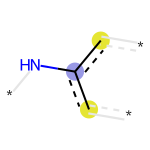

In [16]:
display(Draw.DrawMorganBit(mols[0], 191, bit_info1, useSVG=True))

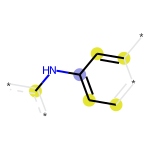

In [17]:
display(Draw.DrawMorganBit(mols[0], 329, bit_info1, useSVG=True))

Raios diferentes codificam subestruturas diferentes:
- `radius=1` significa 1 átomo (e ligações) de distância do átomo central
- `radius=2` significa 2 átomos (e suas ligações) de distância do átomo central

Nesse caso, o mesmo átomo central foi codificado em subestruturas diferentes: cada bit corresponde a uma _feature_ única da molécula.

### O que significam bits ativados por mais de um átomo, com mesmo valor de raio?

**Exemplo 1**

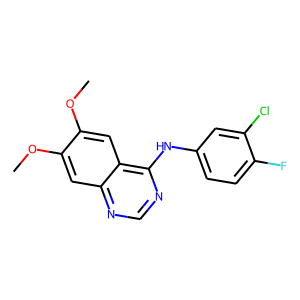

In [18]:
display(Draw.MolToImage(mols[0]))

In [19]:
list(bit_info1.items())[:5]

[(191, ((10, 1),)),
 (216, ((12, 2),)),
 (249, ((1, 2), (21, 2))),
 (329, ((10, 2),)),
 (366, ((15, 1),))]

Bit '249' foi ativado com raio 2 pelos átomos '1' e '21'.

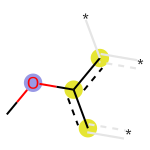

In [20]:
display(Draw.DrawMorganBit(mols[0], 249, bit_info1, useSVG=True))

Se observamos a molécula completa vemos que a subestrutra codificada está presente mais de uma vez, daí ela aparecer duas vezes no dicionário de `bit_info`.

**Exemplo 2**

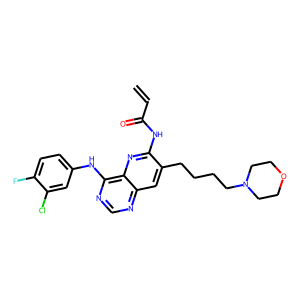

In [21]:
display(Draw.MolToImage(mols[1]))

In [22]:
list(bit_info2.items())[:5]

[(50, ((21, 2),)),
 (80, ((24, 0), (25, 0), (26, 0), (27, 0))),
 (161, ((2, 2),)),
 (191, ((10, 1),)),
 (216, ((12, 2),))]

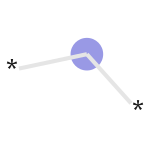

In [23]:
display(Draw.DrawMorganBit(mols[1], 80, bit_info2, useSVG=True))

Nesse exemplo o bit '80' é "ativado" 4 vezes, pelos átomos '24'até '27'. Se observamos a representação 2D da molécula completa, vemos, novamente, que há 4 carbonos com duas ligações simples. Daí os quatro elementos da tupla no dicionário correspondentes à chave '80'.

### O que significa o mesmo bit ativado em moléculas diferentes

In [24]:
print('Molecule at index 0')
pprint(list(bit_info1.items())[:5])
print('-'*20)
print('Molecule at index 1')
pprint(list(bit_info2.items())[:5])

Molecule at index 0
[(191, ((10, 1),)),
 (216, ((12, 2),)),
 (249, ((1, 2), (21, 2))),
 (329, ((10, 2),)),
 (366, ((15, 1),))]
--------------------
Molecule at index 1
[(50, ((21, 2),)),
 (80, ((24, 0), (25, 0), (26, 0), (27, 0))),
 (161, ((2, 2),)),
 (191, ((10, 1),)),
 (216, ((12, 2),))]


Vemos que os bits '191' e '216' estão presentes nas duas moléculas.

**Visualizando as subestruturas correspondentes ao bit '191':**

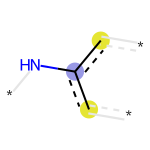

In [25]:
svg = Draw.DrawMorganBit(mols[0], 191, bit_info1, useSVG=True)
svg

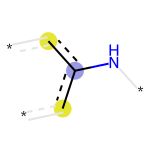

In [26]:
svg = Draw.DrawMorganBit(mols[1], 191, bit_info2, useSVG=True)
svg

Apesar de rotacionada, a subestrutura representada é a mesma nos dois casos:
- um átomo central de carbono com:
    - ligações aromáticas com outros dois carbonos (no anel aromático)
    - ligação simples com um nitrogênio

**E o bit '216'?**

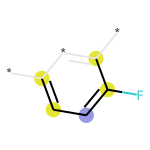

In [27]:
display(Draw.DrawMorganBit(mols[0], 216, bit_info1, useSVG=True))

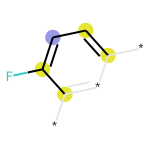

In [28]:
display(Draw.DrawMorganBit(mols[1], 216, bit_info2, useSVG=True))

Novamente temos a mesma subestrutura representada, apesar da rotação nas imagens:
- átmoco central de carbono com:
    - ligação aromática com 2 outros carbonos (raio=1):
        - um dos quais (direita na figura) faz ligação aromática com outro carbono dentro do anel (raio 2)
        - outro (à esquerda) faz:
            - uma ligação aromática com outro carbono dentro do anel
            - uma ligação simples com um flúor fora do anel